<p><a name="sections"></a></p>

## Sections

- <a href="#1">Step 1: Import libraries and load dataset</a><br>
- <a href="#2">Step 2: Data Pipeline</a><br>
- <a href="#3">Step 3: Linear Model Preprocessing</a><br>
- <a href="#4">Step 4: Fit Linear Models</a><br>
    - <a href="#lasso">Lasso Model</a><br>
    - <a href="#elasticnet">ElasticNet Model</a><br>
    - <a href="#bayesian">Bayesian Ridge Model</a><br>
- <a href="#5">Step 5: Tree Model Preprocessing</a><br>
- <a href="#6">Step 6: Fit Tree Model</a><br>
- <a href="#7">Step 7: Ensemble Models</a><br>
- <a href="#8">Step 8: K-means Clustering</a><br>

<p><a name="1"></a></p>

## Step1: Import libraries and load csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.preprocessing import StandardScaler,LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as ms
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tools.tools import add_constant
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv",)
df_test = pd.read_csv("test.csv")

In [3]:
print("Training data set dimensions: ", df_train.shape)
print("Testing data set dimensions: ", df_test.shape)

Training data set dimensions:  (1460, 81)
Testing data set dimensions:  (1459, 80)


**Combining both dataframes so we can transform them at once**

In [4]:
df_combined = df_train.append(df_test,sort = False)
df_combined

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


**Checking Missing Values**

In [5]:
df_combined.isnull().sum()[df_combined.isnull().sum()>0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

<p><a name="2"></a></p>

## Step 2: Data Pipeline

### Helper Functions

In [6]:
def create_custom_features(df1):
    """
    Input Parameter: a dataframe
    This function will return a new dataframe with 5 custom features added: AdjTotalBasmSF, 
    AdjTotalBath, HouseAge, AdjOutdoorSF and LogSalePrice
    
    """
    df = df1.copy()
    df['AdjTotalBsmtSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + 0.9*df['BsmtUnfSF']
    df['AdjTotalBath'] = df['FullBath'] + df['BsmtFullBath'] + 0.6*(df['HalfBath'] + df['BsmtHalfBath'])
    df['HouseAge'] = df['YrSold']-(0.6*df['YearRemodAdd'] + 0.4*df['YearBuilt'])
    df['AdjOutdoorSF'] = df['3SsnPorch'] + df['EnclosedPorch'] + df['OpenPorchSF'] + df['ScreenPorch'] + df['WoodDeckSF']
    df['LogSalePrice'] = np.log(df['SalePrice'])
    return df

In [7]:
def indices_of_outliers(df,col_name, threshold = 5, printDetails = False):
    """
    Input parameters:
    - df: a dataframe
    - col_name: the column header
    - threshold: standard deviation threashold used to define outliers 
    - printDetails: Allows users to choose whether or not to see the details
    
    Returns a list of indices containing outliers 
    """
    avg = df[col_name].mean()
    std = df[col_name].std()
    mask = np.abs(df[col_name] - avg) >= (threshold*std)
    indices = list(set(df.index[mask].tolist()))
    if printDetails:
        print('There are %i outliers in %s.' %(len(indices), col_name))
        print('Their indices are:', indices)
    return indices

In [8]:
def remove_outliers(df,col_names):
    """
    Input parameters:
    - df: a dataframe
    - col_names: a list of columns 
    
    This function will call the indices_of_outliers
    """
    lst_indices = []
    for col in col_names:
        lst_indices.extend(indices_of_outliers(df,col))
    lst_indices = list(set(lst_indices))
    return df.drop(df.index[lst_indices])

In [9]:
def replace_NA_with_None(df, col_names):
    """
    Input parameters:
    - df: a dataframe
    - col_names: a list of columns to be modified
    
    Some features contain NAs which represents 'None'. This function will return a new dataframe 
    with NA replaced by 'None'.
    """
    df_copy = df.copy()
    for col in col_names:
        df_copy.loc[df_copy[col].isna(), col] = 'None'
    return df_copy 

In [10]:
def impute_NAs(df1, printDetails = False):
    df = df1.copy()
    # For houses without LotFrontage, use the median from that neighborhood
    df['LotFrontage'] = df.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['MasVnrType'] = df.groupby(['Neighborhood'])['MasVnrType'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # Where there is no MasVnrType, assign the missing values of area to be zero
    mask_1 = (df["MasVnrType"] == "None") & (df["MasVnrArea"].isna())
    df.loc[mask_1, "MasVnrArea"]  = 0.0
    
    # There is 1 house with a "stone" type MasVnrType, with no area, so we impute using median area for stone types
    df['MasVnrArea'] = df.groupby(['MasVnrType'])['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
    
    # There is one house in test set that containing missing value in GarageArea, seems like it does not have a Garage
    df['GarageArea']= df['GarageArea'].fillna(0)
    df['GarageCars']= df['GarageCars'].fillna(0)
    
    # Only one house has missing value in BsmtSF due to no basement, should fill NA with 0
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
    df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)
    
    # There are 2 houses that have missing values in basement bathroom due to no basement 
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
    df['Exterior1st'] = df.groupby(['RoofMatl'])['Exterior1st'].transform(lambda x: x.fillna(x.mode()[0])) 
    df['Exterior2nd'] = df.groupby(['RoofMatl'])['Exterior2nd'].transform(lambda x: x.fillna(x.mode()[0])) 
    df['KitchenQual'] = df.groupby(['OverallCond'])['KitchenQual'].transform(lambda x: x.fillna(x.mode()[0])) # group by Overall Condition
    
    # 2 houses have missing values in Functional. Both are in poor quality condition and sold as abnormal type. Should not consider it as Functional_typ
    df['Functional'] = df['Functional'].fillna('Mod')
    
    # 4 houses having missing values in MSZoning
    df['MSZoning'] = df.groupby(['Neighborhood'])['MSZoning'].transform(lambda x:x.fillna(x.mode()[0]))
    df['Utilities'] = df['Utilities'].fillna('AllPub')
    df['SaleType'] = df.groupby(['SaleCondition'])['SaleType'].transform(lambda x: x.fillna(x.mode()[0]))
    
    if printDetails:
        print("Imputed NA's in:")
        print("LotFrontage, Electrical, MasVnrType, GarageArea, GarageCars, TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, BsmtFullBath, BsmtHalfBath, Exterior1st, Exterior2nd, KitchenQual, Functional, MSZoning, Utilities, SaleType")
    
    return df

In [11]:
def dummify_categorical(df1, col_names):
    """
    Input Parameters:
    - df1: a dataframe
    - col_names: a list of columns
    
    This function will return a new dataframe with the specified columns dummified, 
    and only keep the groups that have a count greater than 145. 
    
    """
    df = df1.copy()
    for col in col_names:
        grouped = df.groupby(col)[[col]].agg('count').rename(columns={col:'count'}).\
                  sort_values(by = "count", ascending = False)
        df = pd.get_dummies(df, columns=[col], prefix=col, prefix_sep='_') 
        columns_to_drop = list(grouped.loc[grouped['count']<145].index)
        columns_to_drop = [col + "_" + i for i in columns_to_drop]
        if len(columns_to_drop) > 0:
            df = df.drop(columns = columns_to_drop,axis = 1)
        else:
            df = df.drop(col + "_" + grouped.index[0], axis=1)
    return df

In [12]:
def impute_ordinal(df1, list_of_dic):
    """
    Input Parameters:
    - df1: a dataframe
    - list_of_dic: a list of dictionary to map ordinal features to numbers
    
    Returns a new data frame with ordinal features mapped by the specified dictionary
    """
    df = df1.copy()
    for dic in list_of_dic:
        df = df.replace(dic)
    return df

### Imputing Missing Values

**Replace NA's by None for columns that NA means no such feature**

In [13]:
columns = ['BsmtExposure','BsmtQual','FireplaceQu','GarageQual','GarageType','GarageYrBlt','GarageFinish',\
           'GarageCond','PoolQC','Fence','MiscFeature','Alley','BsmtCond','BsmtFinType1','BsmtFinType2']
df_combined = replace_NA_with_None(df_combined, columns)

**Replace NA's in other columns by mean/median/mode using the helper function**

In [14]:
df_combined = impute_NAs(df_combined)
df_combined.loc[:,df_combined.isna().any()]

,SalePrice
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0
...,...
1454,NaN
1455,NaN
1456,NaN
1457,NaN


The only missing values are in SalePrice from the test dataset because the test dataset does not have SalePrice.

### Create Customized Features

In [15]:
df_combined = create_custom_features(df_combined)
df_combined.shape

(2919, 86)

<p><a name="3"></a></p>

## Step3: Preprocessing for Linear Models

### Dummify Categorical Features 

In [16]:
lst_ordinal = ["BsmtExposure", "BsmtQual", "ExterQual", "FireplaceQu","KitchenQual", "GarageQual",
               "HeatingQC", "BsmtCond","ExterCond","GarageCond"]
others = ["Fence", "PoolQC", "GarageYrBlt"]

In [17]:
lst_categorical = [ x for x in df_combined.select_dtypes(include =[object]).columns if (x not in lst_ordinal) & (x not in others)]
df_dummified = dummify_categorical(df_combined, lst_categorical)

In [18]:
df_dummified

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,GarageFinish_None,GarageFinish_RFn,PavedDrive_N,PavedDrive_Y,MiscFeature_None,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,Gd,...,0,1,0,1,1,0,1,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,TA,...,0,1,0,1,1,0,1,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,Gd,...,0,1,0,1,1,0,1,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,TA,...,0,0,0,1,1,0,1,1,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,Gd,...,0,1,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,TA,...,1,0,0,1,1,0,1,0,1,0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,TA,...,0,0,0,1,1,0,1,1,0,0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,TA,...,0,0,0,1,1,0,1,1,0,0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,TA,...,1,0,0,1,0,0,1,0,1,0


### Map Ordinal Features to Numeric

In [19]:
list_of_dic= [{"BsmtExposure": {"Gd": 5, "Av": 4, "Mn": 3, "No": 2, "None": 0}},
              {"BsmtQual": {"Ex": 7, "Gd": 4, "TA": 2, "Fa": 1, "Po": 0, "None": 0}},
              {"ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 1}}, 
              {"FireplaceQu": {"Ex": 5, "Gd": 3, "TA": 2.5, "Fa": 1.5, "Po":0, "None": 0.5}},
              {"KitchenQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1}},   
              {"GarageQual": {"Ex": 5, "Gd": 5, "TA": 4.5, "Fa": 2.5, "Po": 1, "None": 1}},
              {"HeatingQC": {"Ex": 3, "Gd": 2, "TA": 1.5, "Fa": 1, "Po": 0}},
              {"BsmtCond": {"Gd":7, "TA":6, "Fa": 4,"None": 3, "Po": 0}},
              {"ExterCond": {"Ex":7, "TA":6, "Gd": 5,"Fa": 2, "Po": 0}},
              {"GarageCond": {"Ex":3, "TA":6, "Gd": 6,"Fa": 1, "Po": 1, "None":0}}]

df_ordinal_dummified = impute_ordinal(df_dummified,list_of_dic)

In [20]:
lst_dummified = list(df_ordinal_dummified.filter(regex='_').columns)

In [21]:
lst_numeric = ['AdjTotalBsmtSF', 'GarageArea', 'GrLivArea', 'HouseAge', 'LotArea','AdjTotalBath', 'AdjOutdoorSF', 
               'OverallQual', 'BedroomAbvGr', 'Fireplaces', 'LotFrontage', 'MasVnrArea', "BsmtUnfSF",
                "LowQualFinSF", "MiscVal"]

In [22]:
lst_predictors = lst_dummified + lst_ordinal + lst_numeric

### Split Train and Test Data

In [23]:
df_train = df_ordinal_dummified.iloc[:1460,]
df_test = df_ordinal_dummified.iloc[1460:,]

### Remove Outliers for Train using helper function

In [24]:
df_without_outliers = remove_outliers(df_train,lst_numeric)
print('%i rows are removed.' %(len(df_train)-len(df_without_outliers)))

36 rows are removed.


<p><a name="4"></a></p>

## Step 4: Fitting Linear Models

### Check Multicollinearity using VIF

In [25]:
VIF = add_constant(df_without_outliers.loc[:,lst_numeric])
pd.Series([variance_inflation_factor(VIF.values, i) for i in range(VIF.shape[1])], index=VIF.columns)

const             77.344146
AdjTotalBsmtSF     1.927784
GarageArea         1.855823
GrLivArea          3.591806
HouseAge           2.297718
LotArea            1.479966
AdjTotalBath       2.822233
AdjOutdoorSF       1.251750
OverallQual        2.947152
BedroomAbvGr       1.738915
Fireplaces         1.434320
LotFrontage        1.425895
MasVnrArea         1.318286
BsmtUnfSF          1.680152
LowQualFinSF       1.023394
MiscVal            1.012163
dtype: float64

All are below threshold of 5, suggesting a low/no multicollinearity. 

<p><a name="lasso"></a></p>

### 1. Lasso Model

**Feature Selections using Lasso**

In [26]:
X = df_without_outliers[lst_predictors]
Y = df_without_outliers['LogSalePrice'].values

In [27]:
lasso_FS = Lasso(normalize=True, max_iter = 10000)
alpha_FS = np.logspace(-9, -2, 100)

alpha_coefs = []
for alpha in alpha_FS:
    lasso_FS.set_params(alpha=alpha)
    lasso_FS.fit(X, Y)
    alpha_coefs.append(lasso_FS.coef_)

coefs_df = pd.DataFrame(alpha_coefs, index=alpha_FS, columns = lst_predictors)

Coefficients vs. $\lambda$

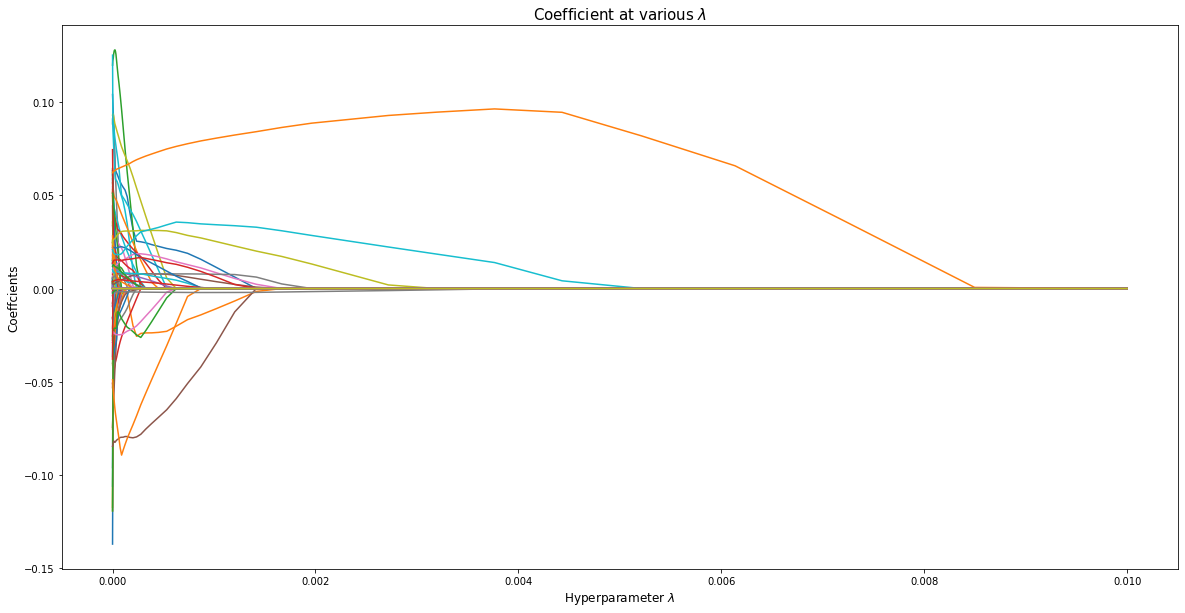

In [28]:
plt.figure(figsize=(20,10))
for name in coefs_df.columns:
    plt.plot(coefs_df.index, coefs_df[name], label=name);
plt.xlabel(r'Hyperparameter $\lambda$',fontsize = 12)
plt.ylabel(r'Coeffcients',fontsize = 12)
plt.title('Coefficient at various $\lambda$',fontsize = 15);

Find the $\lambda$ when each coefficeint becomes zero

In [29]:
alpha_zero = {}
for col in coefs_df.columns:
    for alpha in coefs_df.index:
        if coefs_df.loc[alpha, col] == 0:
            alpha_zero[col] = alpha
            break
alpha_zero = sorted(alpha_zero.items(), key=lambda x: x[1], reverse=True)

Select the Top 60 Features

In [30]:
top_features = [item[0] for item in alpha_zero[:60]]

Using the top 60 features to build a Lasso Model

In [31]:
X_after_FS = X[top_features].values

Split the training data into 80% and 20%

In [32]:
X_train, X_test, y_train, y_test = ms.train_test_split(X_after_FS, Y, train_size=0.8, test_size=0.2, random_state=42)

**Cross Validate to find optimal $\lambda$**

In [33]:
alphas_lasso = np.logspace(-9, -3.5, 100)
lasso = Lasso(normalize=True)

dic = {}
for alpha in alphas_lasso:
    lasso.set_params(alpha=alpha)
    rmse = np.sqrt(-ms.cross_val_score(lasso, X_train, y_train, 
                      scoring="neg_mean_squared_error",cv = 5))
    dic[alpha] = np.mean(rmse)

alpha_rmse = pd.DataFrame.from_dict(dic, orient='index', columns = ['RMSE']).reset_index()

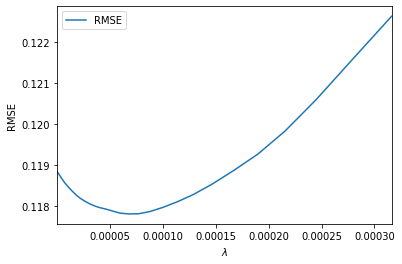

In [34]:
alpha_rmse.plot(x = "index", y = "RMSE")
plt.xlabel("$\lambda$")
plt.ylabel("RMSE");

In [35]:
alpha_optimal = alpha_rmse.sort_values(by='RMSE').iloc[0,0]

**Removing Outliers that are widly mispredicted by the Lasso**

In [36]:
lasso_2 = Lasso(normalize = True, alpha = alpha_optimal)
lasso_2.fit(X_train,y_train)
Y_predicted = lasso_2.predict(X_train)
residuals = y_train - Y_predicted

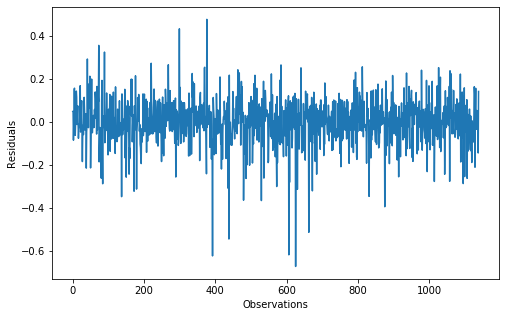

In [37]:
plt.figure(figsize=(8,5))
plt.ylabel("Residuals")
plt.xlabel("Observations")
plt.plot(residuals);

In [38]:
outliers_indices = list(itertools.chain(*np.argwhere(abs(residuals)>0.5)))
outliers_indices

[392, 438, 606, 625, 662]

In [39]:
X_train_no_outliers = pd.DataFrame(X_train).drop(outliers_indices)
y_train_no_outliers = pd.DataFrame(y_train).drop(outliers_indices).values.flatten()

**Repeat cross validation to find optimal $\lambda$**

In [40]:
alphas_lasso_2 = np.logspace(-9, -4, 100)
lasso_2 = Lasso(normalize=True)

dic_2 = {}
for alpha in alphas_lasso_2:
    lasso_2.set_params(alpha=alpha)
    rmse_2 = np.sqrt(-ms.cross_val_score(lasso_2, X_train_no_outliers, y_train_no_outliers, 
                      scoring="neg_mean_squared_error",cv = 5))
    dic_2[alpha] = np.mean(rmse_2)

alpha_rmse_2 = pd.DataFrame.from_dict(dic_2, orient='index', columns = ['RMSE']).reset_index()

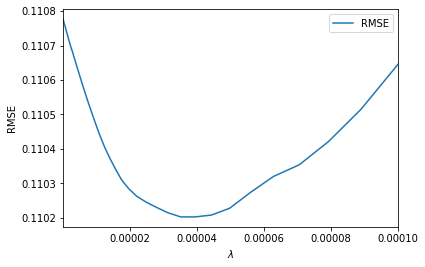

In [41]:
alpha_rmse_2.plot(x = "index", y = "RMSE")
plt.xlabel("$\lambda$")
plt.ylabel("RMSE");

In [42]:
alpha_optimal_2 = alpha_rmse_2.sort_values(by='RMSE').iloc[0,0]

**Fit 80% of Train data using the optimal $\lambda$**

In [43]:
lasso_3 = Lasso(normalize=True,alpha = alpha_optimal_2)
lasso_3.fit(X_train_no_outliers,y_train_no_outliers)

y_train_predicted = lasso_3.predict(X_train_no_outliers)
RMSE_train = np.sqrt(mean_squared_error(y_train_no_outliers,y_train_predicted))

y_test_predicted = lasso_3.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,y_test_predicted))

print('RMSE for train data is: %.3f.' % RMSE_train)
print('RMSE for test data is: %.3f.' % RMSE_test)

RMSE for train data is: 0.102.
RMSE for test data is: 0.139.


**Prediction on Test Data**

In [44]:
df_test_predictors = df_test[top_features]

In [45]:
Predicted_LogPrice = lasso_3.predict(df_test_predictors)
Predicted_Price = np.exp(Predicted_LogPrice)
Final_Price_Lasso = pd.DataFrame(np.concatenate([df_test[['Id']],pd.DataFrame(Predicted_Price)],axis=1))
Final_Price_Lasso.columns= ['Id','SalePrice']
Final_Price_Lasso['Id'] = Final_Price_Lasso['Id'].astype('int32')
Final_Price_Lasso.head(5)

,Id,SalePrice
0,1461,112345.212946
1,1462,168198.382666
2,1463,177052.079750
3,1464,191834.339508
4,1465,177071.343786


In [46]:
Final_Price_Lasso.to_csv("test_price_lasso.csv",index = False)

<p><a name="elasticnet"></a></p>

### 2. Elastic Net Model

In [47]:
elasticnet = ElasticNet()
elasticnet.set_params(normalize=True, alpha = 0.0001, l1_ratio = 0.5)
elasticnet.fit(X_train,y_train)
print("R^2 for elasticnet model is: %.3f" % elasticnet.score(X_train,y_train))
y_train_predicted = elasticnet.predict(X_train)
y_test_predicted = elasticnet.predict(X_test)
print("RMSE_train for elasticnet model is: %.3f" % np.sqrt(mean_squared_error(y_train,y_train_predicted)))
print("RMSE_test for elasticnet model is: %.3f" % np.sqrt(mean_squared_error(y_test,y_test_predicted)))

R^2 for elasticnet model is: 0.921
RMSE_train for elasticnet model is: 0.111
RMSE_test for elasticnet model is: 0.138


**GridSearch to find optimal $\lambda$ and l1 ratio**

In [48]:
alphas = np.logspace(-9, 0, 10).tolist()
l1_ratios = np.linspace(0.001, 0.95, 10).tolist()
elasticnet_params = [{'alpha': alphas, 'l1_ratio': l1_ratios}]
elasticnet = ElasticNet(normalize=True)
elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv = 5, scoring = "neg_mean_squared_error")
elasticnet_grid.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                    0.001, 0.01, 0.1, 1.0],
                          'l1_ratio': [0.001, 0.10644444444444444,
                                       0.21188888888888888, 0.3173333333333333,
                                       0.42277777777777775, 0.5282222222222221,
                                       0.6336666666666666, 0.739111111111111,
                                       0.8445555555555555, 0.95]}],
             pre_dispatch='2*n_jobs', refit=T

In [49]:
print("Best parameters:",elasticnet_grid.best_params_)

Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.8445555555555555}


**Using the best params to make prediction**

In [50]:
y_train_predicted = elasticnet_grid.predict(X_train)
RMSE_train = np.sqrt(mean_squared_error(y_train,y_train_predicted))
y_test_predicted = elasticnet_grid.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,y_test_predicted))

print('RMSE for train data using ElasticNet is: %.3f' % RMSE_train)
print('RMSE for test data using ElasticNet is: %.3f' % RMSE_test)

RMSE for train data using ElasticNet is: 0.111
RMSE for test data using ElasticNet is: 0.138


In [51]:
Predicted_LogPrice_ElasticNet = elasticnet_grid.predict(df_test_predictors)
Predicted_Price_ElasticNet = np.exp(Predicted_LogPrice_ElasticNet)
Final_Price_ElasticNet = pd.DataFrame(np.concatenate([df_test[['Id']],pd.DataFrame(Predicted_Price_ElasticNet)],axis=1))
Final_Price_ElasticNet.columns= ['Id','SalePrice']
Final_Price_ElasticNet['Id'] = Final_Price_ElasticNet['Id'].astype('int32')
Final_Price_ElasticNet.head()

,Id,SalePrice
0,1461,113626.830359
1,1462,167416.907144
2,1463,176676.300622
3,1464,194666.870207
4,1465,180217.482439


In [52]:
Final_Price_ElasticNet.to_csv("test_ElasticNet_price.csv",index = False)

<p><a name="bayesian"></a></p>

### 3. Bayesian Ridge Regression

**5-fold Cross Validation on 4 hyperparmeters**
- https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression
- https://en.wikipedia.org/wiki/Bayesian_linear_regression

In [53]:
np.logspace(-14, -10, 5)

array([1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10])

In [54]:
br_model = BayesianRidge(normalize = True)
br_params = [{'alpha_1':np.logspace(-14, -10, 5),'alpha_2':np.logspace(-2, 2, 5),
             'lambda_1':np.logspace(0, 4, 5),'lambda_2':np.logspace(-4, 0, 5)}]

br_gridSearch = GridSearchCV(br_model, br_params, cv = 5, scoring = "neg_mean_squared_error")
br_gridSearch.fit(X, Y)
print("Best parameters after the grid search:",br_gridSearch.best_params_)

Best parameters after the grid search: {'alpha_1': 1e-10, 'alpha_2': 1.0, 'lambda_1': 10.0, 'lambda_2': 1.0}


In [55]:
Predicted_LogPrice_br = br_gridSearch.predict(df_test[lst_predictors])
Predicted_Price_br= np.exp(Predicted_LogPrice_br)
Final_Price_BR = pd.DataFrame(np.concatenate([df_test[['Id']],pd.DataFrame(Predicted_Price_br)],axis=1))
Final_Price_BR.columns= ['Id','SalePrice']
Final_Price_BR['Id'] = Final_Price_BR['Id'].astype('int32')
Final_Price_BR.head(5)

,Id,SalePrice
0,1461,108866.638201
1,1462,209963.798641
2,1463,177440.774771
3,1464,191967.813203
4,1465,184426.741080


In [56]:
Final_Price_BR.to_csv("test_bayesian_ridge_price.csv",index = False)

<p><a name="5"></a></p>

## Step 5: Preprocessing for tree models

**Transform categorical features to numeric using LabelEncoder**

In [57]:
le = LabelEncoder()
df_categorical = df_combined.select_dtypes(include=[object]).drop('GarageYrBlt',axis =1) # 43 categorical columns
categorical_columns = list(df_categorical.columns)
df_categorical_le = df_categorical.apply(le.fit_transform)
df_categorical_le.head(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4


**Combining categorical and numeric columns**

In [58]:
df_numeric = df_combined._get_numeric_data() 
numeric_columns = list(df_numeric.columns)
df_le = pd.DataFrame(np.concatenate([df_numeric,df_categorical_le],axis = 1))
df_le.columns = numeric_columns + categorical_columns
df_le

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915.0,160.0,21.0,1936.0,4.0,7.0,1970.0,1970.0,0.0,0.0,...,6.0,1.0,3.0,3.0,2.0,3.0,4.0,1.0,8.0,4.0
2915,2916.0,160.0,21.0,1894.0,4.0,5.0,1970.0,1970.0,0.0,252.0,...,4.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
2916,2917.0,20.0,160.0,20000.0,5.0,7.0,1960.0,1996.0,0.0,1224.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
2917,2918.0,85.0,62.0,10441.0,5.0,5.0,1992.0,1992.0,0.0,337.0,...,6.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,8.0,4.0


**Split train and test data set**

In [59]:
X = df_le.iloc[:1460,:].drop(['Id','SalePrice','LogSalePrice'],axis =1)
Y = df_le.iloc[:1460,]['SalePrice']
X_Original_Test = df_le.iloc[1460:,].drop(['SalePrice','LogSalePrice'],axis =1) 

In [60]:
X.shape

(1460, 82)

<p><a name="6"></a></p>

## Step 6: Fit Tree Model (GBM)

**Initial GBM Model Fit**

In [61]:
gbm = GradientBoostingRegressor()
gbm.set_params(verbose = 1)
gbm.fit(X,Y)
print('Score of the GBM model is %.2f' %gbm.score(X,Y))

      Iter       Train Loss   Remaining Time 
         1  5414666697.2413            0.79s
         2  4670811099.6029            0.73s
         3  4064945702.8768            0.68s
         4  3559917680.1599            0.67s
         5  3127159220.5939            0.64s
         6  2766554720.6472            0.62s
         7  2464020257.2934            0.62s
         8  2206444029.1449            0.62s
         9  1981905228.2157            0.63s
        10  1784535935.3719            0.61s
        20   809356353.9819            0.53s
        30   510647600.5843            0.44s
        40   392797074.0168            0.38s
        50   327028738.4629            0.31s
        60   292320602.2855            0.25s
        70   267473609.2618            0.19s
        80   245723125.3323            0.12s
        90   233105582.0757            0.06s
       100   217394185.9758            0.00s
Score of the GBM model is 0.97


**Train Test Split**

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state = 42)

**Stochastic Gradient Boosting (subsampling)**

In [63]:
gbm.set_params(learning_rate=0.03, n_estimators=800, verbose=1, subsample=0.7, warm_start=False, loss='ls', max_depth=4, max_features=2, min_impurity_decrease=0.01,random_state = 42)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.03, loss='ls', max_depth=4,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [64]:
gbm.fit(X_train,Y_train)
print("\nThe train set R^2 is %.3f." %(gbm.score(X_train, Y_train)))
print("The test set R^2 is %.3f." %(gbm.score(X_test,Y_test)))
print("The difference between test and train is %.3f." %(gbm.score(X_train, Y_train)-gbm.score(X_test,Y_test)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6239899733.6282   189658659.6929            0.80s
         2  5111332888.0278   140094527.3009            0.80s
         3  5676701913.3351   170003276.1288            0.79s
         4  5075219257.6807   121462807.0714            0.79s
         5  4991088058.6958   149680039.9634            0.63s
         6  5151590159.1290   129730646.4157            0.66s
         7  4844030871.3334   131100810.1966            0.68s
         8  4676630057.5156   124751570.6961            0.69s
         9  4720404395.2354   118879092.9074            0.70s
        10  4218205891.5667   121122143.5240            0.71s
        20  3354110972.8322    99498119.4699            0.62s
        30  2334621037.4883    52231976.3445            0.59s
        40  2140248366.2105    41738024.7627            0.57s
        50  1535943374.3546    22245469.6500            0.52s
        60  1253395542.1490    21140811.1962            0.50s
       

**Use feature importance to select the top 35 features**

In [65]:
sorted_importance = sorted(zip(X.columns.values, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_top35 = sorted_importance[:35]

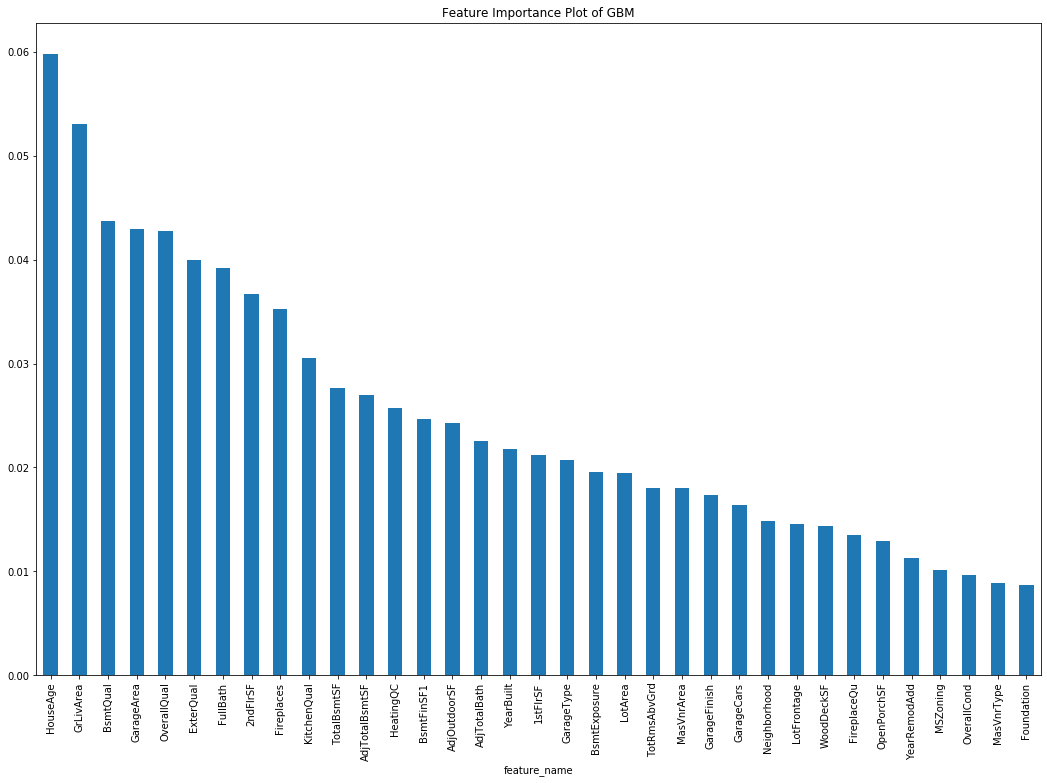

In [66]:
plt.rcParams['figure.figsize'] = (18,12)
a, b = zip(*sorted_importance_top35) 
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
feature_selected = a
plt.title('Feature Importance Plot of GBM');

In [67]:
X_top35 = X.loc[:,list(feature_selected)]
X_Original_Test_Predictor = X_Original_Test.loc[:,list(feature_selected)]
X_top35.head(5)

,HouseAge,GrLivArea,BsmtQual,GarageArea,OverallQual,ExterQual,FullBath,2ndFlrSF,Fireplaces,KitchenQual,...,Neighborhood,LotFrontage,WoodDeckSF,FireplaceQu,OpenPorchSF,YearRemodAdd,MSZoning,OverallCond,MasVnrType,Foundation
0,5.0,1710.0,2.0,548.0,7.0,2.0,2.0,854.0,0.0,2.0,...,5.0,65.0,0.0,3.0,61.0,2003.0,3.0,5.0,1.0,2.0
1,31.0,1262.0,2.0,460.0,6.0,3.0,2.0,0.0,1.0,3.0,...,24.0,80.0,298.0,5.0,0.0,1976.0,3.0,8.0,2.0,1.0
2,6.4,1786.0,2.0,608.0,7.0,2.0,2.0,866.0,1.0,2.0,...,5.0,68.0,0.0,5.0,42.0,2002.0,3.0,5.0,1.0,2.0
3,58.0,1717.0,4.0,642.0,7.0,3.0,1.0,756.0,1.0,2.0,...,6.0,60.0,0.0,2.0,35.0,1970.0,3.0,5.0,2.0,0.0
4,8.0,2198.0,2.0,836.0,8.0,2.0,2.0,1053.0,1.0,2.0,...,15.0,84.0,192.0,5.0,84.0,2000.0,3.0,5.0,1.0,2.0


**Train Test Split on the top 35 features**

In [68]:
X_top35_train, X_top35_test, Y_top35_train, Y_top35_test = train_test_split(X_top35,Y, test_size=0.2,random_state = 42)

**Use the top 35 features to refit GBM model**

In [69]:
gbm_top35 = GradientBoostingRegressor()
gbm_top35.set_params(learning_rate=0.03, n_estimators=900, verbose=1, subsample=0.7, warm_start=False, loss='ls', max_depth=4, max_features=2, min_impurity_decrease=0.01,random_state = 42)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.03, loss='ls', max_depth=4,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=900,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [70]:
gbm_top35.fit(X_top35_train,Y_top35_train)
a = gbm_top35.score(X_top35_train, Y_top35_train)
b = gbm_top35.score(X_top35_test,Y_top35_test)
print("\nThe train set R^2 is %.3f" %a)
print("The test set R^2 is %.3f" %b)
print("Difference between train and test set R^2 is %.3f" % (a-b))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6247726367.8379   180808607.9897            0.89s
         2  5051668642.3950   207795156.8871            0.89s
         3  5562933517.6264   182623794.3848            0.89s
         4  4906762315.1391   198891698.0178            0.89s
         5  4783098351.9904   167540982.1750            0.89s
         6  4910303393.5195   151347408.7333            0.89s
         7  4584462122.2585   160860868.2296            0.89s
         8  4381381391.0880   149312049.1506            0.89s
         9  4393708917.1968   114953307.1110            0.89s
        10  3873151071.8057   157741833.0142            0.89s
        20  2806324532.7957    71461868.2699            0.70s
        30  1812210709.5940    57052434.9068            0.64s
        40  1666870532.0326    29562514.6414            0.62s
        50  1179746108.1741    18310061.1663            0.64s
        60   888336578.5751    22051101.5548            0.81s
       

**Grid Search to Tune hyperparameters**

In [71]:
grid_para_tree = [{'n_estimators':np.arange(500,1000,100),
                   'learning_rate':np.linspace(0.02,0.05,10),
                   'min_samples_split': np.linspace(start=6, stop=16, num=7, dtype=int)}]

gbm_top35.set_params(random_state=42)
grid_search_tree = GridSearchCV(gbm_top35, grid_para_tree, cv=3, n_jobs=6)
%time grid_search_tree.fit(X_top35_train, Y_top35_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6214216091.7554   199157238.7609            0.88s
         2  5005135943.9599   242237675.0714            0.89s
         3  5494538460.1003   200112907.3206            0.89s
         4  4789976436.3665   243842874.6772            0.89s
         5  4651120777.5112   199664439.7951            0.89s
         6  4739852911.8858   153011989.8939            0.89s
         7  4415489181.8236   172633958.1502            0.89s
         8  4182511974.6457   171961781.5633            0.89s
         9  4190947803.7962   121691194.8689            0.89s
        10  3667620127.2430   188397504.0994            0.89s
        20  2583304378.7283    71943736.7264            0.75s
        30  1627060238.1732    55664393.0946            0.72s
        40  1465147318.6565    30854116.4280            0.69s
        50  1033397761.7657    16482491.1738            0.66s
        60   790864152.8503    16325308.6963            0.66s
       

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.03,
                                                 loss='ls', max_depth=4,
                                                 max_features=2,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.01,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=900,
                                                 n_iter_no...
                            

In [72]:
print('Best Parameters are: ',grid_search_tree.best_params_)

Best Parameters are:  {'learning_rate': 0.03333333333333333, 'min_samples_split': 11, 'n_estimators': 900}


In [73]:
print("Train set score is: %.3f" % grid_search_tree.score(X_top35_train, Y_top35_train))
print("Test set score is: %.3f" % grid_search_tree.score(X_top35_test, Y_top35_test))

Train set score is: 0.988
Test set score is: 0.920


**Using the best parameters to predict house price on test data**

In [74]:
Predicted_test_price = grid_search_tree.predict(X_Original_Test_Predictor)
Final_Price_GBM = pd.DataFrame(np.concatenate([pd.DataFrame(X_Original_Test['Id']),pd.DataFrame(Predicted_test_price)],axis=1))
Final_Price_GBM.columns= ['Id','SalePrice']
Final_Price_GBM['Id'] = Final_Price_GBM['Id'].astype('int32')
Final_Price_GBM.head(5)

,Id,SalePrice
0,1461,132127.027709
1,1462,161057.770814
2,1463,190688.933371
3,1464,202627.325208
4,1465,192296.019318


In [75]:
Final_Price_GBM.to_csv("test_price_GBM.csv", index = False)

<p><a name="7"></a></p>

## Step 7: Ensemble Models

In [76]:
Final_Price_ensemble = Final_Price_Lasso.copy()
Final_Price_ensemble['SalePrice'] = Final_Price_Lasso['SalePrice']*0.2+ Final_Price_BR['SalePrice']*0.3 + \
                                    Final_Price_GBM['SalePrice']*0.5
Final_Price_ensemble.head()

,Id,SalePrice
0,1461,121192.547904
1,1462,177157.701532
2,1463,183987.115067
3,1464,197270.874466
4,1465,186890.300740


In [77]:
Final_Price_ensemble.to_csv("test_price_ensemble_3models.csv", index = False)

<p><a name="8"></a></p>

## Step 8: K-means Clustering

**Use the top 35 features ranked by GBM**

In [78]:
X_kmeans = X[list(feature_selected)]
X_kmeans.head(n = 5)

,HouseAge,GrLivArea,BsmtQual,GarageArea,OverallQual,ExterQual,FullBath,2ndFlrSF,Fireplaces,KitchenQual,...,Neighborhood,LotFrontage,WoodDeckSF,FireplaceQu,OpenPorchSF,YearRemodAdd,MSZoning,OverallCond,MasVnrType,Foundation
0,5.0,1710.0,2.0,548.0,7.0,2.0,2.0,854.0,0.0,2.0,...,5.0,65.0,0.0,3.0,61.0,2003.0,3.0,5.0,1.0,2.0
1,31.0,1262.0,2.0,460.0,6.0,3.0,2.0,0.0,1.0,3.0,...,24.0,80.0,298.0,5.0,0.0,1976.0,3.0,8.0,2.0,1.0
2,6.4,1786.0,2.0,608.0,7.0,2.0,2.0,866.0,1.0,2.0,...,5.0,68.0,0.0,5.0,42.0,2002.0,3.0,5.0,1.0,2.0
3,58.0,1717.0,4.0,642.0,7.0,3.0,1.0,756.0,1.0,2.0,...,6.0,60.0,0.0,2.0,35.0,1970.0,3.0,5.0,2.0,0.0
4,8.0,2198.0,2.0,836.0,8.0,2.0,2.0,1053.0,1.0,2.0,...,15.0,84.0,192.0,5.0,84.0,2000.0,3.0,5.0,1.0,2.0


**Use the elbow method to find the optimal number of clusters**

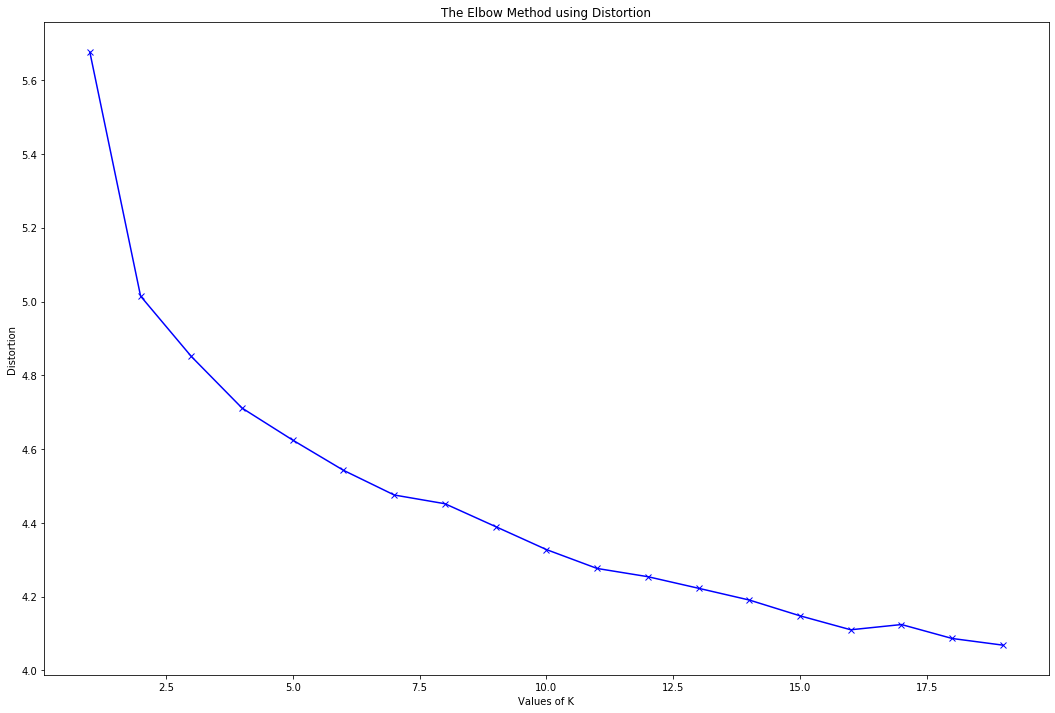

In [79]:
scaler = StandardScaler()
scaler.fit(X_kmeans)
X_kmeans_scaled = scaler.transform(X_kmeans)

distortions = []
K_max = 20
K = range(1, K_max) 
  
for k in K: 
    kmeanModel = KMeans(n_clusters=k) 
    kmeanModel.fit(X_kmeans_scaled)     
    distortions.append(sum(np.min(cdist(X_kmeans_scaled, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]) 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show();

**Fit k-means with 6 clusters**

In [80]:
cluster = KMeans(n_clusters = 6, n_init = 10)
cluster.fit(X_kmeans_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [81]:
X_kmeans['cluster'] = cluster.labels_
X_kmeans['SalePrice'] = df_train['SalePrice']
X_kmeans

,HouseAge,GrLivArea,BsmtQual,GarageArea,OverallQual,ExterQual,FullBath,2ndFlrSF,Fireplaces,KitchenQual,...,WoodDeckSF,FireplaceQu,OpenPorchSF,YearRemodAdd,MSZoning,OverallCond,MasVnrType,Foundation,cluster,SalePrice
0,5.0,1710.0,2.0,548.0,7.0,2.0,2.0,854.0,0.0,2.0,...,0.0,3.0,61.0,2003.0,3.0,5.0,1.0,2.0,5,208500.0
1,31.0,1262.0,2.0,460.0,6.0,3.0,2.0,0.0,1.0,3.0,...,298.0,5.0,0.0,1976.0,3.0,8.0,2.0,1.0,4,181500.0
2,6.4,1786.0,2.0,608.0,7.0,2.0,2.0,866.0,1.0,2.0,...,0.0,5.0,42.0,2002.0,3.0,5.0,1.0,2.0,5,223500.0
3,58.0,1717.0,4.0,642.0,7.0,3.0,1.0,756.0,1.0,2.0,...,0.0,2.0,35.0,1970.0,3.0,5.0,2.0,0.0,0,140000.0
4,8.0,2198.0,2.0,836.0,8.0,2.0,2.0,1053.0,1.0,2.0,...,192.0,5.0,84.0,2000.0,3.0,5.0,1.0,2.0,5,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7.4,1647.0,2.0,460.0,6.0,3.0,2.0,694.0,1.0,3.0,...,0.0,5.0,40.0,2000.0,3.0,5.0,2.0,2.0,5,175000.0
1456,26.0,2073.0,2.0,500.0,6.0,3.0,2.0,0.0,2.0,3.0,...,349.0,5.0,0.0,1988.0,3.0,6.0,3.0,1.0,4,210000.0
1457,30.0,2340.0,4.0,252.0,7.0,0.0,2.0,1152.0,2.0,2.0,...,0.0,2.0,60.0,2006.0,3.0,9.0,2.0,4.0,5,266500.0
1458,32.4,1078.0,4.0,240.0,5.0,3.0,1.0,0.0,0.0,2.0,...,366.0,3.0,0.0,1996.0,3.0,6.0,2.0,1.0,2,142125.0


**Aggregation**

In [82]:
features = ["SalePrice", "YearBuilt", "HouseAge", "GrLivArea", "1stFlrSF", "FullBath", "LotFrontage", "OverallQual", "KitchenQual"]
X_kmeans.groupby("cluster")[features].aggregate("median").sort_values("SalePrice", ascending = False)

,SalePrice,YearBuilt,HouseAge,GrLivArea,1stFlrSF,FullBath,LotFrontage,OverallQual,KitchenQual
cluster,,,,,,,,,
3,345000.0,2006.0,1.4,2028.0,1792.0,2.0,86.0,8.0,0.0
5,204875.0,2000.0,7.4,1788.0,927.5,2.0,70.0,7.0,2.0
1,203000.0,2004.0,4.0,1456.0,1442.0,2.0,68.0,7.0,2.0
4,180000.0,1967.0,34.6,1746.5,1424.0,2.0,80.0,6.0,3.0
2,136950.0,1965.0,36.0,1068.5,1046.0,1.0,72.0,5.0,3.0
0,114752.0,1930.0,57.0,1230.0,867.5,1.0,60.0,5.0,3.0
